In [5]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 08 2018

@author: ncaplar@princeton.edu

"""
%connect_info

{
  "stdin_port": 56466, 
  "ip": "127.0.0.1", 
  "control_port": 56467, 
  "hb_port": 56468, 
  "signature_scheme": "hmac-sha256", 
  "key": "dab4b124-ecff08b7cd50c38b71b5f4ec", 
  "kernel_name": "", 
  "shell_port": 56464, 
  "transport": "tcp", 
  "iopub_port": 56465
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-3a925ca0-d8dc-49eb-b1e9-4c9f01f31618.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [6]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}



<IPython.core.display.Javascript object>

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
#import statments
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import io
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

# Theoretical Analysis 

In [10]:
# load precomputed table of autocorrelation functions generated in Wolfram Mathematica notebook
ACFData=np.loadtxt(open('/Users/nevencaplar/Documents/Variability/MainSequence/Github/ACFTableFlatten.csv', "rb"), delimiter=",", skiprows=0)
ACFData[:,1]=np.round(ACFData[:,1],2)
#ACFData=ACFData[np.lexsort((ACFData[:,0], ACFData[:,1],ACFData[:,2]))]

These auto-correlation function have been computed numerically in Wolfram Mathematica (notebook to be attached) for PSD=1/(1+(f/f_bend)^(slope)),
where tau=1/f_bend and f is frequency

They are tabulated as function of tau (Decorrelation time), slope(high frequency slope of the PSD) and time

In [11]:
tau=np.unique(ACFData[:,0])
slope=np.unique(ACFData[:,1])
time=np.unique(ACFData[:,2])
ACF=ACFData[:,3]

print('avaliable tau are: '+str(tau))
print('avaliable slopes are: '+str(slope))
print('largest avaliable time is: '+str(max(time)))

avaliable tau are: [   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   20.   30.
   40.   50.   60.   70.   80.   90.  100.  110.  120.  130.  140.  150.
  160.  170.  180.  190.  200.]
avaliable slopes are: [ 0.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4
  2.5  2.6  2.7  2.8  2.9]
largest avaliable time is: 1000.0


In [12]:
# constructing multi-index panda dataframe (series)
mi = pd.MultiIndex.from_product([tau, slope, time], names=['tau', 'slope', 'time'])

#connect multiindex to data and save as multindexed series
sr_multi = pd.Series(index=mi, data=ACF.flatten())

## Looking at ACF

In [13]:
def get_ACF(tau,slope):
    """!gives autocorrelation function as a 2d numpy array [time, ACF]

    @param[in] tau          Decorrelation time
    @param[in] slope        high frequency slope of the PSD



    """
    
    #pull out a dataframe with tau = 100 time units (see all options above)
    select_tau=sr_multi.xs(tau, level='tau').unstack(level=0)
    #pull out a dataframe with slope = 2
    select_tau_and_slope=select_tau[slope]
    
    res=[]
    for j in range(1,len(select_tau_and_slope.values)):
        res.append([j,select_tau_and_slope.values[j]])
    
    res=np.array(res)
    return res

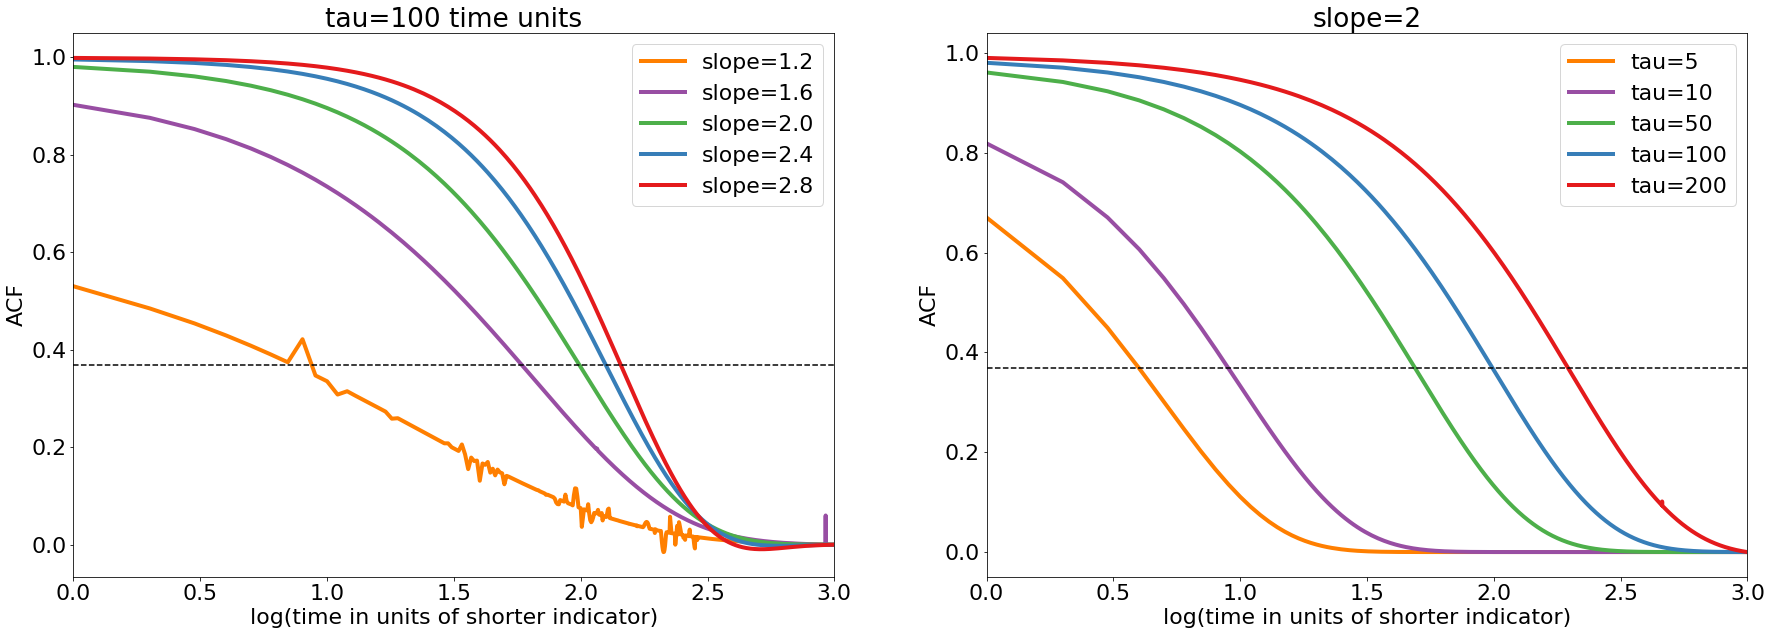

In [14]:
"""
Example showing how ACF depend on slope and tau
For slope 2 (damped random walk) we know the exact result that ACF(t)=exp(-t/tau)
We can verify below that ACF(100)=1/exp(-1) for the case of slope=2

colors from colorbrewer2.org

One can also notice numerical instabilities in the numerical integration for shallow slopes
"""
plot_slope=2
plot_tau=100


plt.figure(figsize=(30,10))

plt.subplot(121)

ACF_Example1=get_ACF(plot_tau,1.2)
ACF_Example2=get_ACF(plot_tau,1.6)
ACF_Example3=get_ACF(plot_tau,2)
ACF_Example4=get_ACF(plot_tau,2.4)
ACF_Example5=get_ACF(plot_tau,2.8)

plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4)
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='#4daf4a',label='slope=2.0',lw=4)
plt.plot(np.log10(ACF_Example4[:,0]),ACF_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4)
plt.plot(np.log10(ACF_Example5[:,0]),ACF_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4)

plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('ACF')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)


plt.subplot(122)
ACF_Example1=get_ACF(5,plot_slope)
ACF_Example2=get_ACF(10,plot_slope)
ACF_Example3=get_ACF(50,plot_slope)
ACF_Example4=get_ACF(100,plot_slope)
ACF_Example5=get_ACF(200,plot_slope)

plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='#984ea3',label='tau=10',lw=4)
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='#4daf4a',label='tau=50',lw=4)
plt.plot(np.log10(ACF_Example4[:,0]),ACF_Example4[:,1],color='#377eb8',label='tau=100',lw=4)
plt.plot(np.log10(ACF_Example5[:,0]),ACF_Example5[:,1],color='#e41a1c',label='tau=200',lw=4)

plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('ACF')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## scatter of the main sequence 

In [15]:
def get_scatter_MS(tau,slope,tMax=None):
    """!gives size of scatter as a 2d numpy array [time, scatter]

    @param[in] tau          Decorellation time
    @param[in] slope        high frequency slope of the PSD
    @param[in] tmax         what is the largest time that you want to consider (see 'largest avaliable time is' above);


    """
    if tMax is None:
        tMax=int(max(time))
    
    ACF=get_ACF(tau,slope)
    
    res=[]
    for t in range(1,tMax):
        res.append([t,(1+2*np.sum(((1-np.array(range(1,t+1))/t))*ACF[:,1][:t]))**(1/2)*(1/(t**(1/2)))])

    res=np.array(res)
    return res

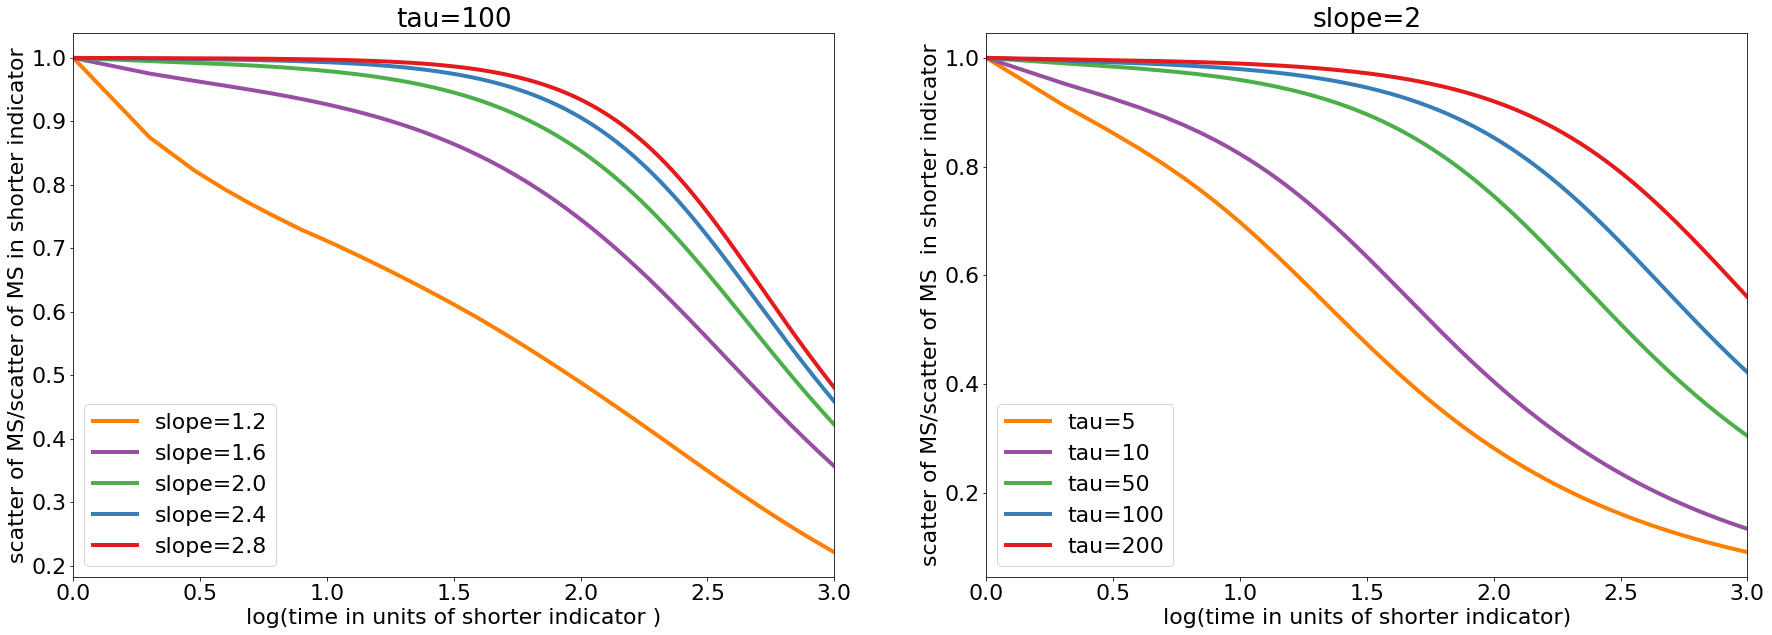

In [19]:
"""
Example showing how scatter depend on slope and tau 
"""
plot_slope=2
plot_tau=100


plt.figure(figsize=(30,10))

plt.subplot(121)

Scatter_Example1=get_scatter_MS(plot_tau,1.2)
Scatter_Example2=get_scatter_MS(plot_tau,1.6)
Scatter_Example3=get_scatter_MS(plot_tau,2)
Scatter_Example4=get_scatter_MS(plot_tau,2.4)
Scatter_Example5=get_scatter_MS(plot_tau,2.8)

plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4)
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='#4daf4a',label='slope=2.0',lw=4)
plt.plot(np.log10(Scatter_Example4[:,0]),Scatter_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4)
plt.plot(np.log10(Scatter_Example5[:,0]),Scatter_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator )')
plt.ylabel('scatter of MS/scatter of MS in shorter indicator')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)



plt.subplot(122)
Scatter_Example1=get_scatter_MS(5,plot_slope)
Scatter_Example2=get_scatter_MS(10,plot_slope)
Scatter_Example3=get_scatter_MS(50,plot_slope)
Scatter_Example4=get_scatter_MS(100,plot_slope)
Scatter_Example5=get_scatter_MS(200,plot_slope)

plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='#984ea3',label='tau=10',lw=4)
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='#4daf4a',label='tau=50',lw=4)
plt.plot(np.log10(Scatter_Example4[:,0]),Scatter_Example4[:,1],color='#377eb8',label='tau=100',lw=4)
plt.plot(np.log10(Scatter_Example5[:,0]),Scatter_Example5[:,1],color='#e41a1c',label='tau=200',lw=4)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('scatter of MS/scatter of MS  in shorter indicator')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## Mean relation 

In [78]:
def get_mean_relation(tau,slope,tMax=None):
    """!gives ratio between mean SFR of a longer indicator and the SFR in a shorten indicator [time, ratio of two indicators ]
        assumes nonchanging mean sequence!

    @param[in] tau          Decorellation time
    @param[in] slope        high frequency slope of the PSD
    @param[in] tmax         what is the largest time that you want to consider (see 'largest avaliable time is' above);


    """
    if tMax is None:
        tMax=int(max(time))
    
    ACF=get_ACF(tau,slope)
    
    res=[]
    for t in range(1,tMax):
        res.append([t,np.sum(ACF[:,1][:t])/(t)])

    res=np.array(res)
    return res

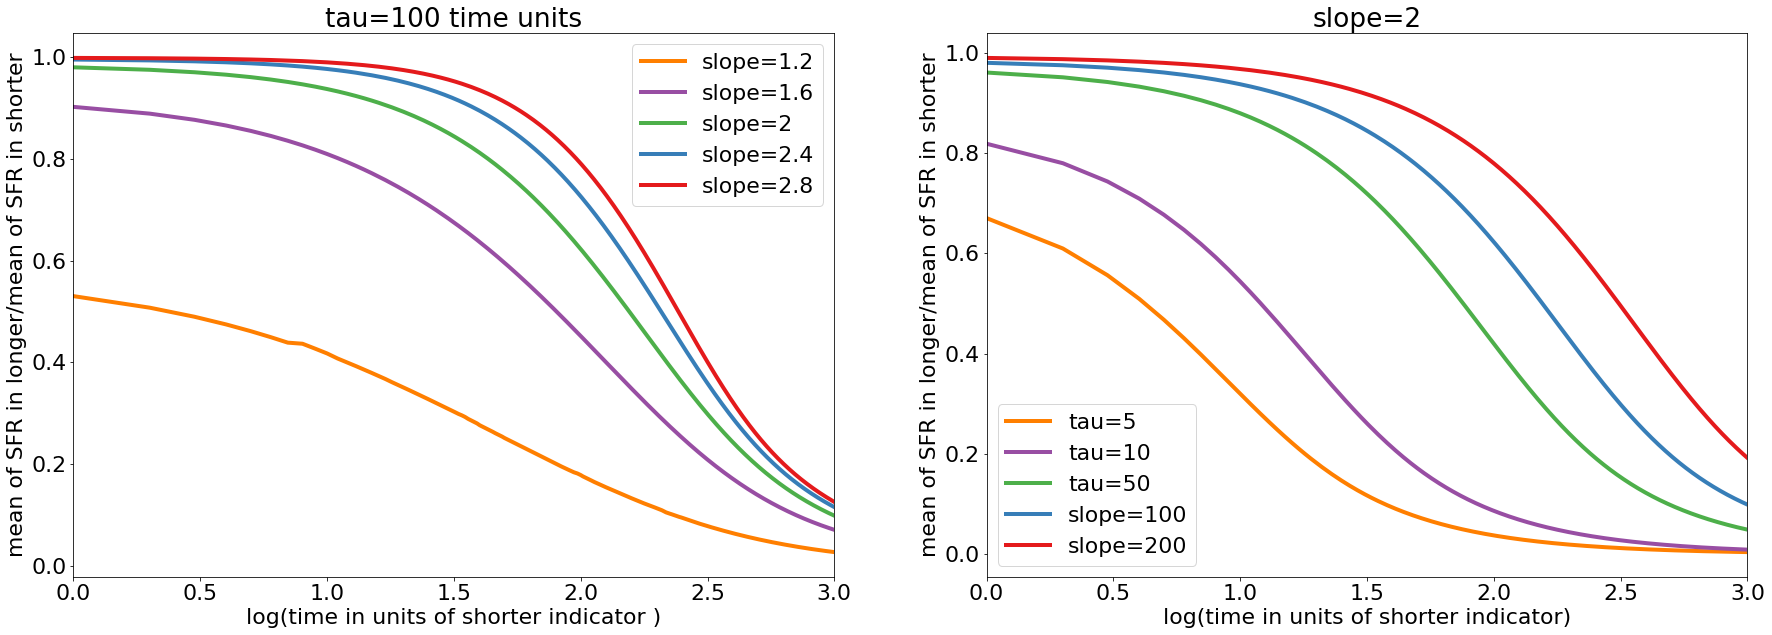

In [80]:
"""
Example showing how mean depend on slope and tau 
"""
plt.figure(figsize=(30,10))

plot_slope=2
plot_tau=100

plt.subplot(121)

Mean_Example1=get_mean_relation(plot_tau,1.2)
Mean_Example2=get_mean_relation(plot_tau,1.6)
Mean_Example3=get_mean_relation(plot_tau,2)
Mean_Example4=get_mean_relation(plot_tau,2.4)
Mean_Example5=get_mean_relation(plot_tau,2.8)

plt.plot(np.log10(Mean_Example1[:,0]),Mean_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(Mean_Example2[:,0]),Mean_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4,)
plt.plot(np.log10(Mean_Example3[:,0]),Mean_Example3[:,1],color='#4daf4a',label='slope=2',lw=4,)
plt.plot(np.log10(Mean_Example4[:,0]),Mean_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4,)
plt.plot(np.log10(Mean_Example5[:,0]),Mean_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4,)
#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator )')
plt.ylabel('mean of SFR in longer/mean of SFR in shorter')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)


plt.subplot(122)
Mean_Example1=get_mean_relation(5,plot_slope)
Mean_Example2=get_mean_relation(10,plot_slope)
Mean_Example3=get_mean_relation(50,plot_slope)
Mean_Example4=get_mean_relation(100,plot_slope)
Mean_Example5=get_mean_relation(200,plot_slope)

plt.plot(np.log10(Mean_Example1[:,0]),Mean_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(Mean_Example2[:,0]),Mean_Example2[:,1],color='#984ea3',label='tau=10',lw=4,)
plt.plot(np.log10(Mean_Example3[:,0]),Mean_Example3[:,1],color='#4daf4a',label='tau=50',lw=4,)
plt.plot(np.log10(Mean_Example4[:,0]),Mean_Example4[:,1],color='#377eb8',label='slope=100',lw=4,)
plt.plot(np.log10(Mean_Example5[:,0]),Mean_Example5[:,1],color='#e41a1c',label='slope=200',lw=4,)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('mean of SFR in longer/mean of SFR in shorter')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## error of SFR_UV at given SFR_Halpha

There is also information in the size of the uncertainty (size of the yellow 'error' bars in the figures below)
Very difficult to observe
I have been struggling to derive these relations theoretically

# Example with generated data 

Below we show few example with generated SFR history curves and show that our theoretical predictions match what is seen in generated data.

In [81]:
from DELCgen import *

## With the same slope, different tau

In [116]:
# amplitude
A=1
#slope on the short time scales
a_low=2.0
#slope on the long time scales
a_high=0
# intercept/offset: adds constant to the final output
c=10

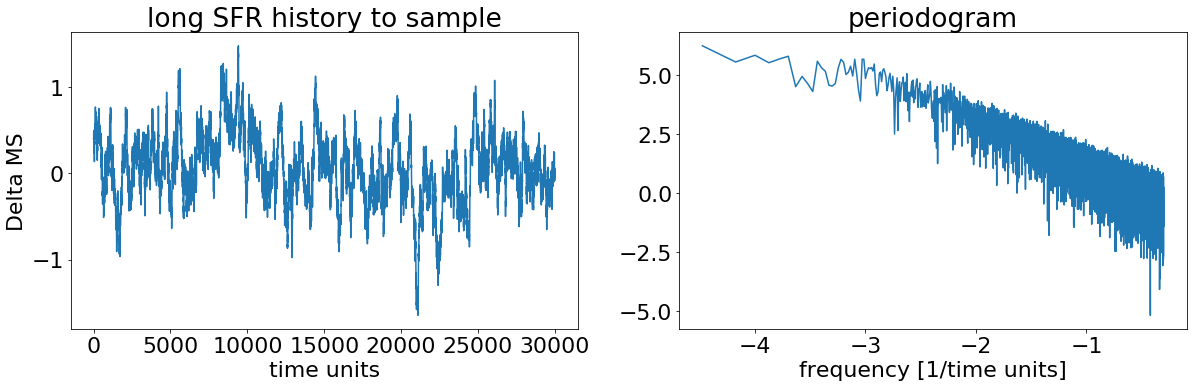

In [117]:
# keep RedNoiseL at least at 10, perhaps 5 if it gets really slow
# Keep aliasTbin=1 


#frequency of the break
v_bend_Example1=1.0/( 20*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example1,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
#Set scatter of the Main Sequence at 0.4 dex in this example
delc_flux_Example1=0.4*delc.flux

#frequency of the break
v_bend_Example2=1.0/(100*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example2,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example2=0.4*delc.flux

#frequency of the break
v_bend_Example3=1.0/( 200*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example3,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example3=0.4*delc.flux

# Plot showing created movement around Main Sequence and the periodogram 
plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(0.4*delc.flux)
plt.title('long SFR history to sample')
plt.xlabel('time units')
plt.ylabel('Delta MS')

plt.subplot(222)
plt.plot(np.log10(delc.periodogram[0]),np.log10(delc.periodogram[1]))
plt.title('periodogram')
plt.xlabel('frequency [1/time units]')

In [118]:
# We use here 'SFR_Halpha' as SFR measured on shorter time scale
# and 'SFR_UV' as SFR measured on longer time scale
# Tmax = answer to the question :How much longer is 'SFR_UV' then 'SFR_Halpha'?
Tmax=100

#generate 'data'
res_Example1=[]
res_Example2=[]
res_Example3=[]
random_start_positions=np.random.randint(0,30000-Tmax,10000)
for i in range(len(random_start_positions)):
    res_Example1.append([delc_flux_Example1[random_start_positions[i]],np.mean(delc_flux_Example1[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example2.append([delc_flux_Example2[random_start_positions[i]],np.mean(delc_flux_Example2[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example3.append([delc_flux_Example3[random_start_positions[i]],np.mean(delc_flux_Example3[random_start_positions[i]:random_start_positions[i]+Tmax])])
   
res_Example1=np.array(res_Example1)    
res_Example2=np.array(res_Example2)    
res_Example3=np.array(res_Example3)  

In [119]:
# estimate mean relation between 'SFR_UV' and 'SFR_Halpha'

SFR_SFR_Example1=[]
SFR_SFR_Example2=[]
SFR_SFR_Example3=[]
for i in np.arange(-1,1,0.05):
    res_Example1_bin=res_Example1[np.all([res_Example1[:,0]<i+0.05, res_Example1[:,0]>i],axis=0)]
    SFR_SFR_Example1.append([np.mean(res_Example1_bin[:,0]),np.mean(res_Example1_bin[:,1]),np.std(res_Example1_bin[:,1])])
    res_Example2_bin=res_Example2[np.all([res_Example2[:,0]<i+0.05, res_Example2[:,0]>i],axis=0)]
    SFR_SFR_Example2.append([np.mean(res_Example2_bin[:,0]),np.mean(res_Example2_bin[:,1]),np.std(res_Example2_bin[:,1])])
    res_Example3_bin=res_Example3[np.all([res_Example3[:,0]<i+0.05, res_Example3[:,0]>i],axis=0)]
    SFR_SFR_Example3.append([np.mean(res_Example3_bin[:,0]),np.mean(res_Example3_bin[:,1]),np.std(res_Example3_bin[:,1])])
    
SFR_SFR_Example1=np.array(SFR_SFR_Example1)
SFR_SFR_Example2=np.array(SFR_SFR_Example2)
SFR_SFR_Example3=np.array(SFR_SFR_Example3)

In [120]:
# theoretical mean relation between 'SFR_UV' and 'SFR_Halpha'

tau_Example1=(1/v_bend_Example1)/(2*np.pi)
SFR_UV_Theoretical_Example1=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example1.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example1,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example1=np.array(SFR_UV_Theoretical_Example1)

tau_Example2=(1/v_bend_Example2)/(2*np.pi)
SFR_UV_Theoretical_Example2=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example2.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example2,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example2=np.array(SFR_UV_Theoretical_Example2)

tau_Example3=(1/v_bend_Example3)/(2*np.pi)
SFR_UV_Theoretical_Example3=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example3.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example3,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example3=np.array(SFR_UV_Theoretical_Example3)

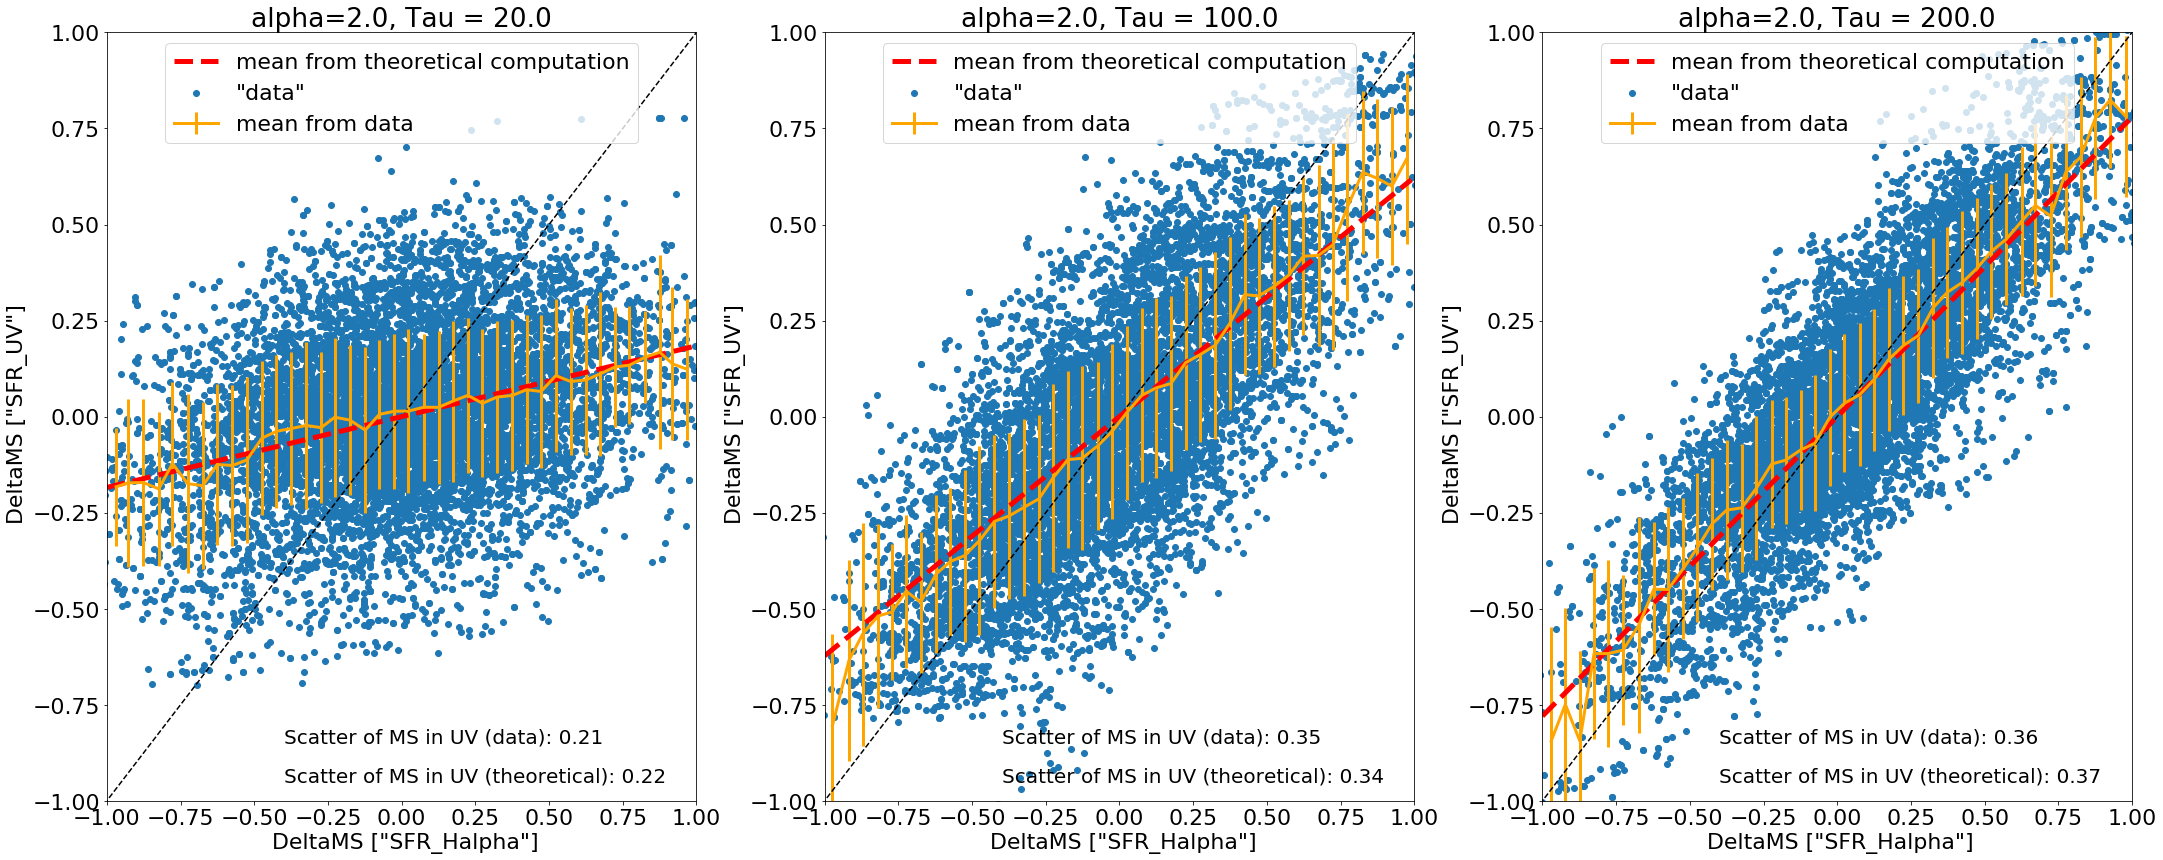

In [121]:
plt.figure(figsize=(30,12))

plt.subplot(1,3,1)
plt.scatter(res_Example1[:,0],res_Example1[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example1[:,0],SFR_SFR_Example1[:,1],yerr=SFR_SFR_Example1[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example1[:,0],SFR_UV_Theoretical_Example1[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example1))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example1[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example1,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,2)
plt.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


plt.subplot(1,3,3)
plt.scatter(res_Example3[:,0],res_Example3[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example3[:,0],SFR_SFR_Example3[:,1],yerr=SFR_SFR_Example3[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example3[:,0],SFR_UV_Theoretical_Example3[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example3))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example3[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example3,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [122]:
print(np.median(SFR_SFR_Example1[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))
print(np.median(SFR_SFR_Example2[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))
print(np.median(SFR_SFR_Example3[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))

0.201407154042
0.227554000409
0.178939208738


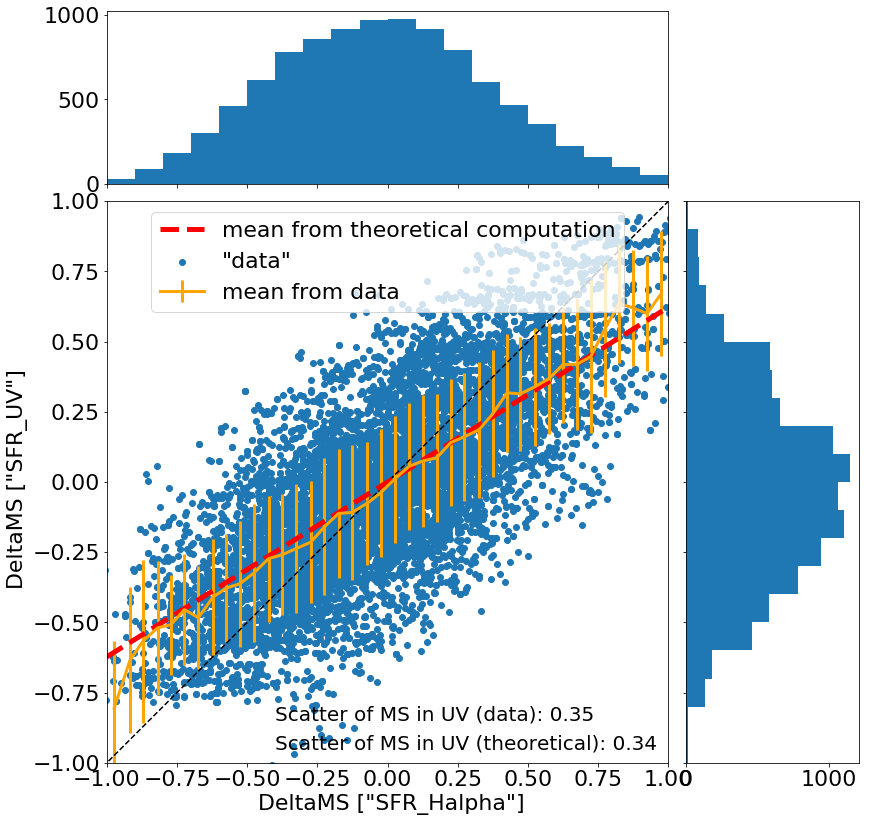

In [123]:
#single plot showing explicity difference in scatter for the middle panel in the Figure above

from matplotlib.ticker import NullFormatter

plt.figure(figsize=(12,12))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(NullFormatter() )
axHisty.yaxis.set_major_formatter(NullFormatter() )

x=res_Example2[:,0]
y=res_Example2[:,1]

axScatter.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
axScatter.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')

axScatter.set_xlabel(' DeltaMS ["SFR_Halpha"]')
axScatter.set_ylabel(' DeltaMS ["SFR_UV"]')
axScatter.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
axScatter.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
axScatter.legend(loc='upper center')
#axScatter.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
axScatter.set_xlim([-1,1])
axScatter.set_ylim(-1,1)
axScatter.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
axScatter.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


# now determine nice limits by hand:
binwidth = 0.1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth


bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()


#plt.xlabel(' DeltaMS ["SFR_Halpha"]')
#plt.ylabel(' DeltaMS ["SFR_UV"]')
#plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
#plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
#plt.legend(loc='9')
#plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
#plt.xlim(-1,1)
#plt.ylim(-1,1)
#plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
#plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

## With the same tau, different slope

In [89]:
# amplitude
A=1
#slope on the long time scales
a_high=0
#frequency of the break
v_bend=1.0/(100*2*np.pi)
# intercept/offset: adds constant to the final output
c=10

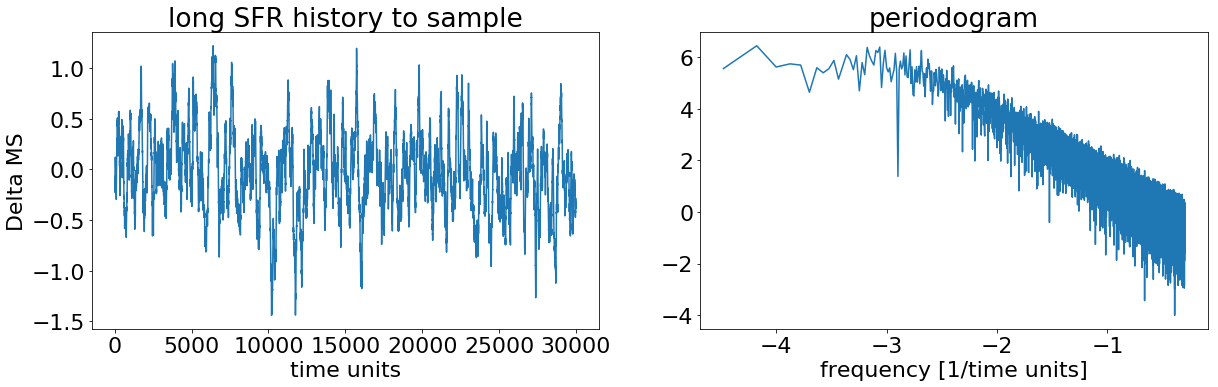

In [90]:
# keep RedNoiseL at least at 10, perhaps 5 if it gets really slow
# Keep aliasTbin=1 

#slope on the short time scales
a_low_Example1=1.5
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example1,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
#Set scatter of the Main Sequence at 0.4 dex in this example
delc_flux_Example1=0.4*delc.flux

#frequency of the break
a_low_Example2=2
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example2,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example2=0.4*delc.flux

#frequency of the break
a_low_Example3=2.5
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example3,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example3=0.4*delc.flux

# Plot showing created movement around Main Sequence and the periodogram 
plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(0.4*delc.flux)
plt.title('long SFR history to sample')
plt.xlabel('time units')
plt.ylabel('Delta MS')

plt.subplot(222)
plt.plot(np.log10(delc.periodogram[0]),np.log10(delc.periodogram[1]))
plt.title('periodogram')
plt.xlabel('frequency [1/time units]')

In [91]:
# We use here 'SFR_Halpha' as SFR measured on shorter time scale
# and 'SFR_UV' as SFR measured on longer time scale
# Tmax = answer to the question :How much longer is 'SFR_UV' then 'SFR_Halpha'?
Tmax=100

#generate 'data'
res_Example1=[]
res_Example2=[]
res_Example3=[]
random_start_positions=np.random.randint(0,30000-Tmax,10000)
for i in range(len(random_start_positions)):
    res_Example1.append([delc_flux_Example1[random_start_positions[i]],np.mean(delc_flux_Example1[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example2.append([delc_flux_Example2[random_start_positions[i]],np.mean(delc_flux_Example2[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example3.append([delc_flux_Example3[random_start_positions[i]],np.mean(delc_flux_Example3[random_start_positions[i]:random_start_positions[i]+Tmax])])
   
res_Example1=np.array(res_Example1)    
res_Example2=np.array(res_Example2)    
res_Example3=np.array(res_Example3)  

In [92]:
# estimate mean relation between 'SFR_UV' and 'SFR_Halpha'

SFR_SFR_Example1=[]
SFR_SFR_Example2=[]
SFR_SFR_Example3=[]
for i in np.arange(-1,1,0.05):
    res_Example1_bin=res_Example1[np.all([res_Example1[:,0]<i+0.05, res_Example1[:,0]>i],axis=0)]
    SFR_SFR_Example1.append([np.mean(res_Example1_bin[:,0]),np.mean(res_Example1_bin[:,1]),np.std(res_Example1_bin[:,1])])
    res_Example2_bin=res_Example2[np.all([res_Example2[:,0]<i+0.05, res_Example2[:,0]>i],axis=0)]
    SFR_SFR_Example2.append([np.mean(res_Example2_bin[:,0]),np.mean(res_Example2_bin[:,1]),np.std(res_Example2_bin[:,1])])
    res_Example3_bin=res_Example3[np.all([res_Example3[:,0]<i+0.05, res_Example3[:,0]>i],axis=0)]
    SFR_SFR_Example3.append([np.mean(res_Example3_bin[:,0]),np.mean(res_Example3_bin[:,1]),np.std(res_Example3_bin[:,1])])
    
SFR_SFR_Example1=np.array(SFR_SFR_Example1)
SFR_SFR_Example2=np.array(SFR_SFR_Example2)
SFR_SFR_Example3=np.array(SFR_SFR_Example3)

In [93]:
# theoretical mean relation between 'SFR_UV' and 'SFR_Halpha'

tau=(1/v_bend)/(2*np.pi)

SFR_UV_Theoretical_Example1=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example1.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example1)[Tmax-1][1]])
SFR_UV_Theoretical_Example1=np.array(SFR_UV_Theoretical_Example1)


SFR_UV_Theoretical_Example2=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example2.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example2)[Tmax-1][1]])
SFR_UV_Theoretical_Example2=np.array(SFR_UV_Theoretical_Example2)


SFR_UV_Theoretical_Example3=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example3.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example3)[Tmax-1][1]])
SFR_UV_Theoretical_Example3=np.array(SFR_UV_Theoretical_Example3)

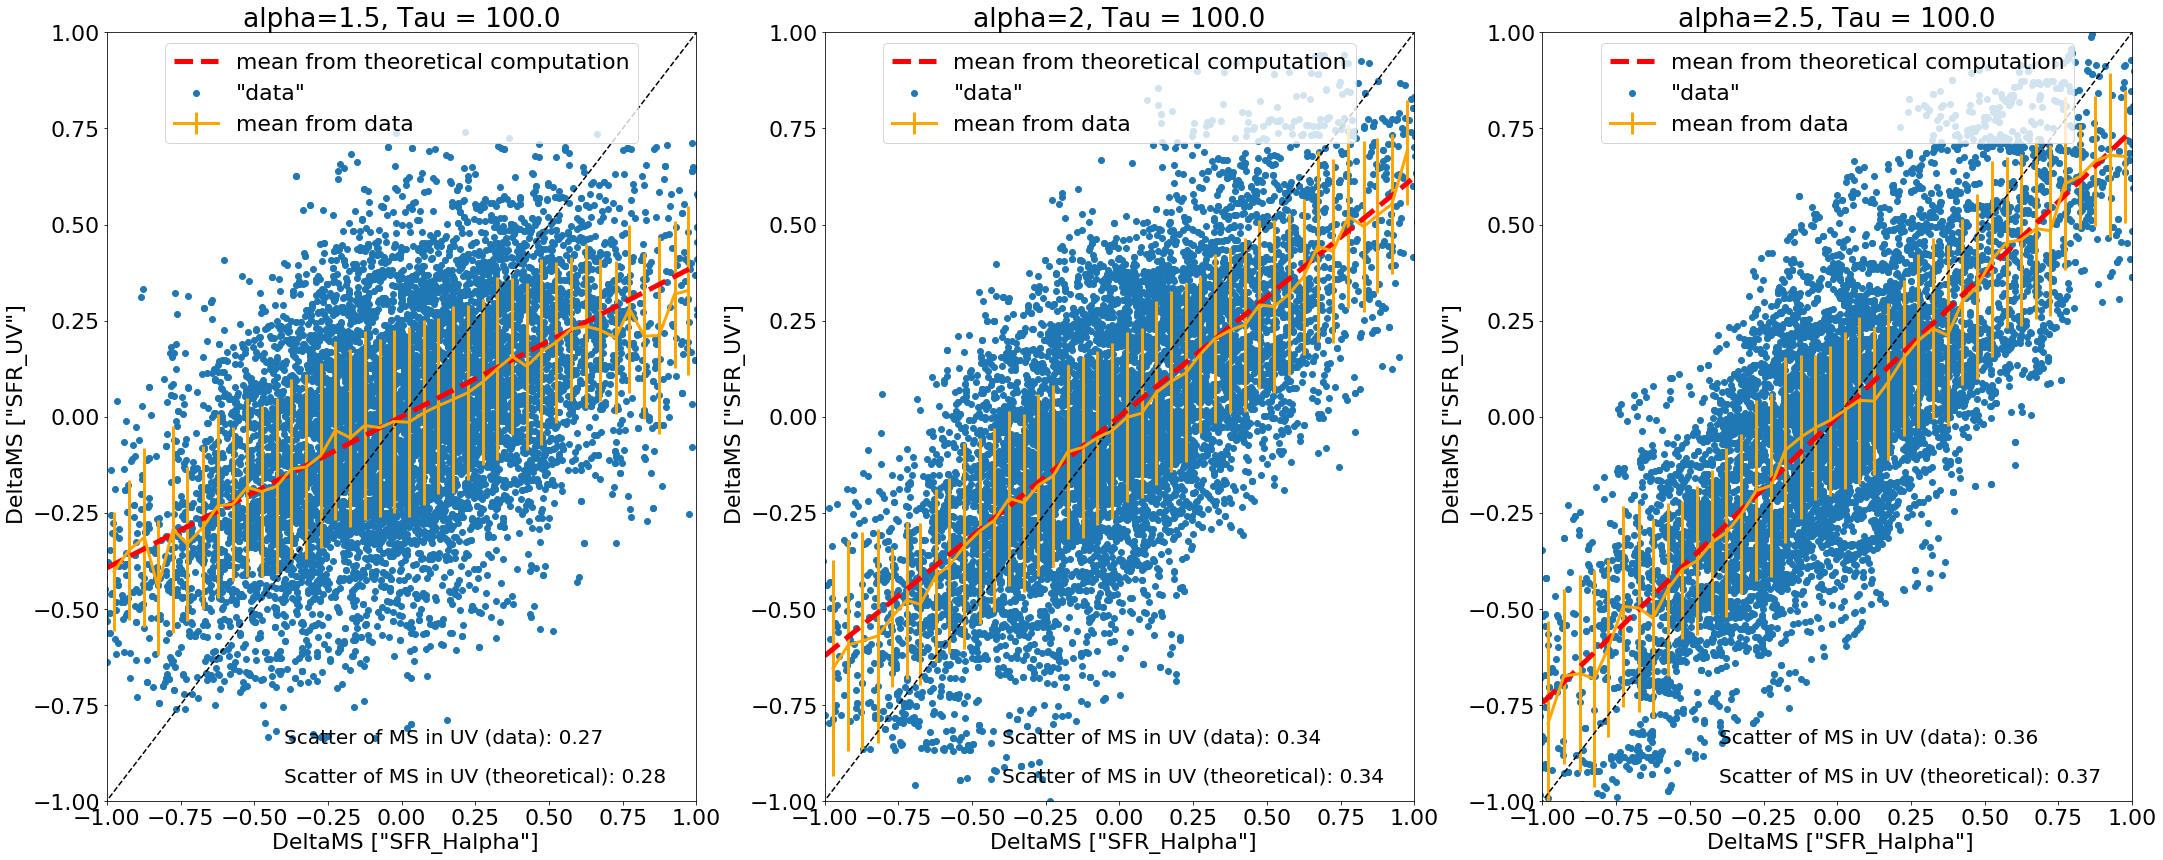

In [94]:
plt.figure(figsize=(30,12))

plt.subplot(1,3,1)
plt.scatter(res_Example1[:,0],res_Example1[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example1[:,0],SFR_SFR_Example1[:,1],yerr=SFR_SFR_Example1[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example1[:,0],SFR_UV_Theoretical_Example1[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example1)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example1[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example1)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,2)
plt.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example2)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example2)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,3)
plt.scatter(res_Example3[:,0],res_Example3[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example3[:,0],SFR_SFR_Example3[:,1],yerr=SFR_SFR_Example3[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example3[:,0],SFR_UV_Theoretical_Example3[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example3)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example3[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example3)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [109]:
#There is also information in the size of the uncertainty (size of the yellow 'error' bars)
# Median size of the ucnertainty for the central parts of the plots above

In [113]:
print(np.median(SFR_SFR_Example1[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))
print(np.median(SFR_SFR_Example2[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))
print(np.median(SFR_SFR_Example3[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))

0.210105393822
0.223897086204
0.210111084222


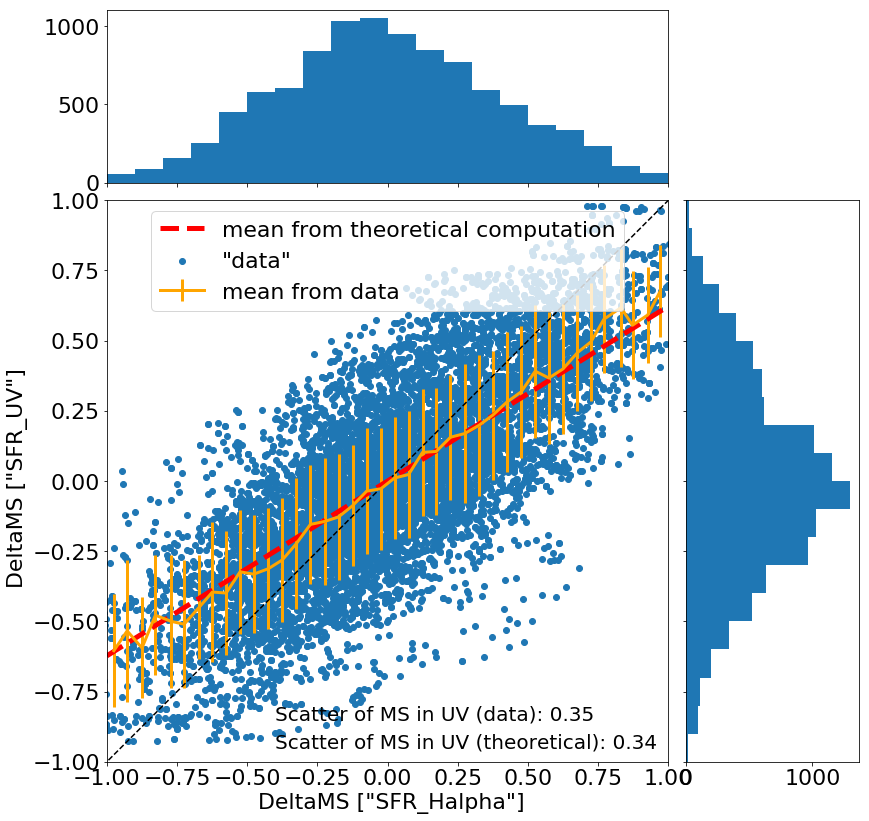

In [115]:
#single plot showing explicity difference in scatter for the middle panel in the Figure above

from matplotlib.ticker import NullFormatter

plt.figure(figsize=(12,12))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(NullFormatter() )
axHisty.yaxis.set_major_formatter(NullFormatter() )

x=res_Example2[:,0]
y=res_Example2[:,1]

axScatter.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
axScatter.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')

axScatter.set_xlabel(' DeltaMS ["SFR_Halpha"]')
axScatter.set_ylabel(' DeltaMS ["SFR_UV"]')
axScatter.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
axScatter.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
axScatter.legend(loc='upper center')
#axScatter.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
axScatter.set_xlim([-1,1])
axScatter.set_ylim(-1,1)
axScatter.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
axScatter.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


# now determine nice limits by hand:
binwidth = 0.1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth


bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()
